In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations
import seaborn as sns

In [3]:
Stage=3
folder_name='experiment and result stage'+str(Stage)
Dataset="fashion" #if baseline then Basline .../...
baseline=None

if baseline:
  x=Dataset+" "+baseline
  filename="Copy of " + x + "_result.csv"
else:
  filename="Copy of " + Dataset + "_result.csv"

methods=['deeplift', 'integrated_gradients']
method='deeplift'
flops_dict = {"branch1": 6.272, "branch2": 56.448, "branch3": 157, "totalFLOPS": 416}
end_epoch=0

In [4]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed data/'
print(save_folder)

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/fashion/Copy of fashion_result.csv
/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/fashion/processed data/


In [5]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

In [6]:
dataframe

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.0,branch2.0,branch3.0,branch4.0,train accuracy epoch0,test accuracy epoch0,method,run
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,361.699756,66.178528,89.493475,175.755420,83.386667,83.65,deeplift,0
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,362.131018,66.264763,89.378277,175.755418,83.386667,83.65,integrated_gradients,0
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,498.407422,57.789075,90.759149,150.908813,84.265000,86.16,deeplift,1
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,498.727614,57.728274,90.774356,150.908809,84.265000,86.16,integrated_gradients,1
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,109.412341,106.210767,49.893542,170.697754,84.345000,87.70,deeplift,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,279.283568,50.745913,71.242503,153.540144,84.385000,85.28,integrated_gradients,12
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,343.934424,48.821121,56.841333,132.079358,84.933333,87.29,deeplift,13
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,342.709942,48.804466,56.856963,132.079345,84.933333,87.29,integrated_gradients,13
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,358.428345,49.598920,24.212935,149.442334,84.611667,87.02,deeplift,14


add flops col

In [7]:
def preprocess_dataframe(df, flops_dict):
    df.rename(columns={'branch1.0': 'branch1', 'branch2.0': 'branch2', 'branch3.0': 'branch3', 'branch4.0': 'branch4'}, inplace=True)

    # Add FLOPS columns
    for col, value in flops_dict.items():
        df[col+"FLOPS"] = value
    return df
df = preprocess_dataframe(dataframe, flops_dict)

In [8]:
df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1,branch2,branch3,branch4,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,361.699756,66.178528,89.493475,175.755420,83.386667,83.65,deeplift,0,6.272,56.448,157,416
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,362.131018,66.264763,89.378277,175.755418,83.386667,83.65,integrated_gradients,0,6.272,56.448,157,416
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,498.407422,57.789075,90.759149,150.908813,84.265000,86.16,deeplift,1,6.272,56.448,157,416
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,498.727614,57.728274,90.774356,150.908809,84.265000,86.16,integrated_gradients,1,6.272,56.448,157,416
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,109.412341,106.210767,49.893542,170.697754,84.345000,87.70,deeplift,2,6.272,56.448,157,416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,279.283568,50.745913,71.242503,153.540144,84.385000,85.28,integrated_gradients,12,6.272,56.448,157,416
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,343.934424,48.821121,56.841333,132.079358,84.933333,87.29,deeplift,13,6.272,56.448,157,416
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,342.709942,48.804466,56.856963,132.079345,84.933333,87.29,integrated_gradients,13,6.272,56.448,157,416
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,358.428345,49.598920,24.212935,149.442334,84.611667,87.02,deeplift,14,6.272,56.448,157,416


normalize layer feature attribution in this stack

In [9]:
def normalize_feature_attribution(df, threshold=70):
    layers=['branch1','branch2','branch3','branch4']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']


    df.drop(['sum_feature_attr','branch1','branch2','branch3','branch4'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

In [10]:
normalized_df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS,norm_branch1,norm_branch2,norm_branch3,norm_branch4,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,83.386667,83.65,deeplift,0,6.272,56.448,157,416,0.521838,0.095478,0.129116,0.253569,83.65
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,83.386667,83.65,integrated_gradients,0,6.272,56.448,157,416,0.522157,0.095547,0.128875,0.253422,83.65
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,84.265000,86.16,deeplift,1,6.272,56.448,157,416,0.624677,0.072430,0.113753,0.189141,86.16
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,84.265000,86.16,integrated_gradients,1,6.272,56.448,157,416,0.624863,0.072329,0.113733,0.189076,86.16
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,84.345000,87.70,deeplift,2,6.272,56.448,157,416,0.250822,0.243483,0.114378,0.391316,87.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,84.385000,85.28,integrated_gradients,12,6.272,56.448,157,416,0.503384,0.091465,0.128408,0.276743,85.28
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,84.933333,87.29,deeplift,13,6.272,56.448,157,416,0.591282,0.083932,0.097720,0.227067,87.29
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,84.933333,87.29,integrated_gradients,13,6.272,56.448,157,416,0.590420,0.084080,0.097953,0.227546,87.29
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,84.611667,87.02,deeplift,14,6.272,56.448,157,416,0.616192,0.085268,0.041626,0.256914,87.02


get standard deviation for each layer's feature attribution

In [11]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1','norm_branch2','norm_branch3','norm_branch4']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [12]:
FA_SD.to_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")

In [13]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1,norm_branch2,norm_branch3,norm_branch4,...,std_norm_branch2,std_norm_branch3,std_norm_branch4,avg_std,train accuracy epoch0,test accuracy epoch0,branch1,branch2,branch3,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.463310,0.101079,0.123262,0.312349,...,0.065605,0.061654,0.086494,0.098668,84.749444,86.508667,6.272,56.448,157,416
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.412302,0.149381,0.165963,0.272355,...,0.080884,0.068327,0.056681,0.091164,84.523444,86.032667,6.272,56.448,157,416
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.362736,0.186718,0.213056,0.237490,...,0.077738,0.067295,0.041953,0.079168,84.156333,85.994667,6.272,56.448,157,416
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.325788,0.218847,0.243121,0.212244,...,0.069230,0.059173,0.031982,0.066706,83.645778,85.959333,6.272,56.448,157,416
4,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.272095,0.090988,0.108861,0.528056,...,0.042235,0.065800,0.114883,0.095344,84.837556,86.504667,6.272,56.448,157,416
5,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.345692,0.103310,0.138451,0.412546,...,0.048044,0.066381,0.101897,0.095851,84.805111,86.504667,6.272,56.448,157,416
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.374005,0.131362,0.150839,0.343794,...,0.050833,0.065817,0.073621,0.086230,84.562111,86.592667,6.272,56.448,157,416
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.361500,0.168812,0.186012,0.283676,...,0.068141,0.060809,0.050181,0.077662,84.226667,86.484000,6.272,56.448,157,416
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.140499,0.100811,0.118053,0.640637,...,0.046336,0.052826,0.057587,0.061197,84.570889,86.168000,6.272,56.448,157,416
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.270635,0.101990,0.127439,0.499936,...,0.041773,0.055695,0.101904,0.086004,84.722667,86.578667,6.272,56.448,157,416


# Graph

In [14]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['std_norm_branch1',	'std_norm_branch2',	'std_norm_branch3',	'std_norm_branch4', 'avg_std']

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Standard Deviation for Different {hyperparam} Values')
    plt.ylabel('Standard Deviation')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()

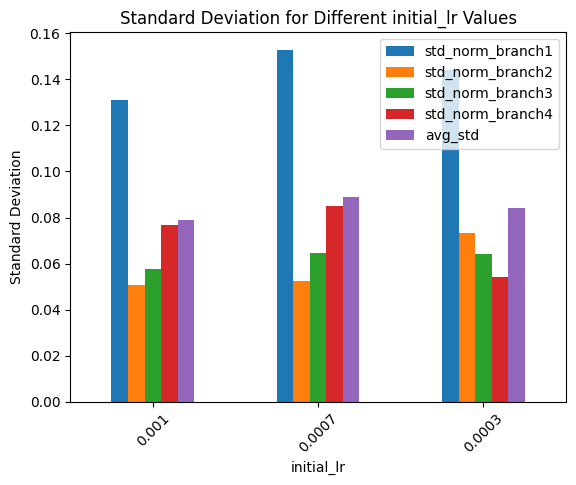

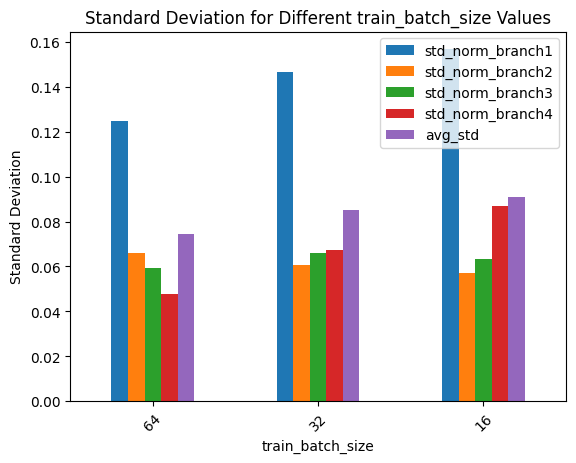

In [15]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

In [16]:
def plot_bee_swarm_for_norm_fa(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['norm_branch1', 'norm_branch2', 'norm_branch3', 'norm_branch4']

    # Preparing data for plotting in long format
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var][variance_columns]
        subset = subset.melt(var_name='Branch', value_name='Variance')
        subset[hyperparam] = var
        plot_data = pd.concat([plot_data, subset])

    # Creating the bee swarm plot
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x=hyperparam, y='Variance', hue='Branch', data=plot_data)
    plt.title(f'Bee Swarm Plot of feature attribution for Different {hyperparam} Values')
    plt.ylabel('Feature Attribution')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.legend(title='Branch')
    plt.show()


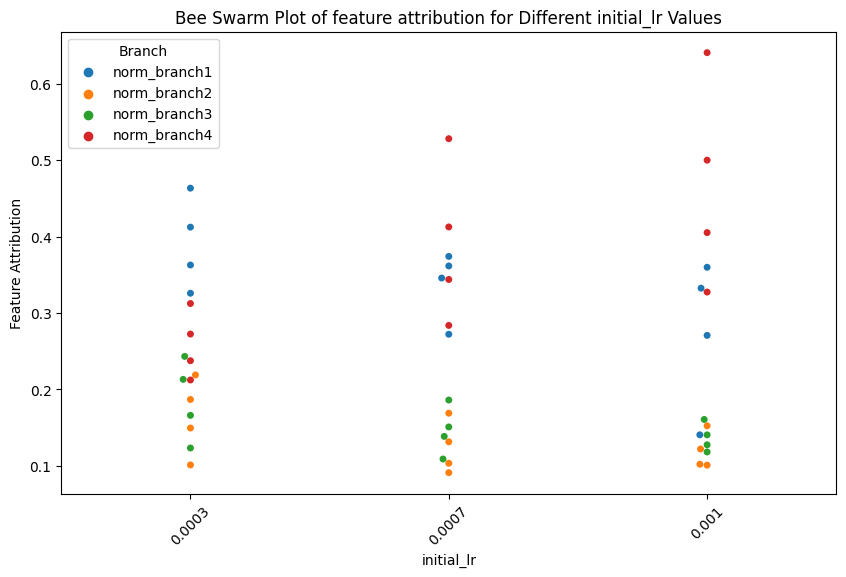

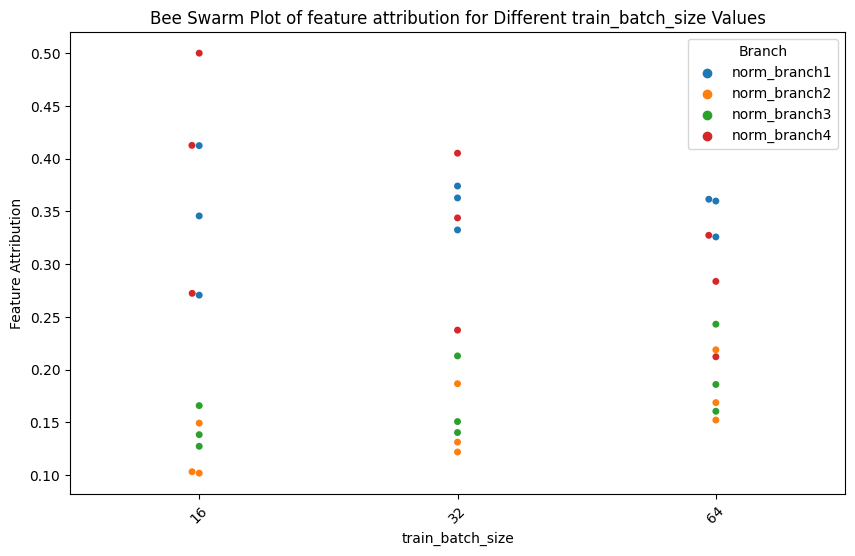

In [17]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(FA_SD, hyperparam, variables)

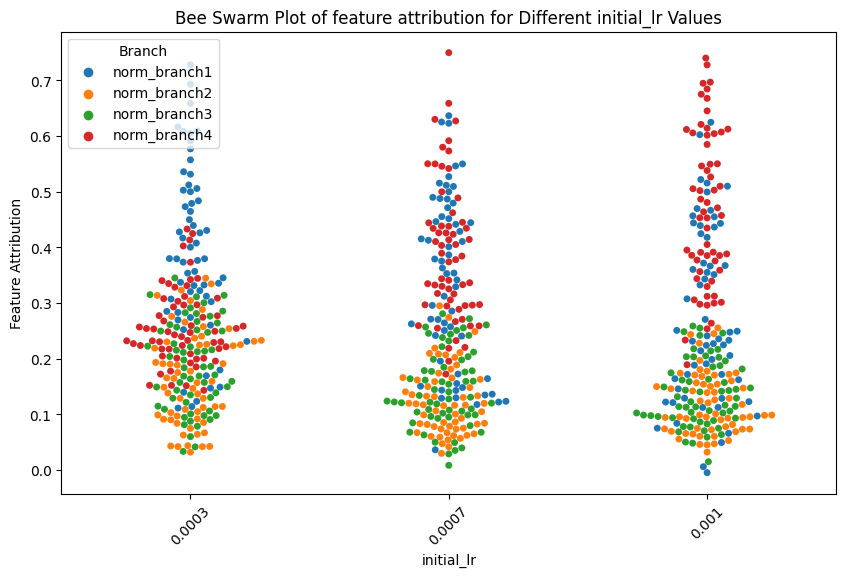

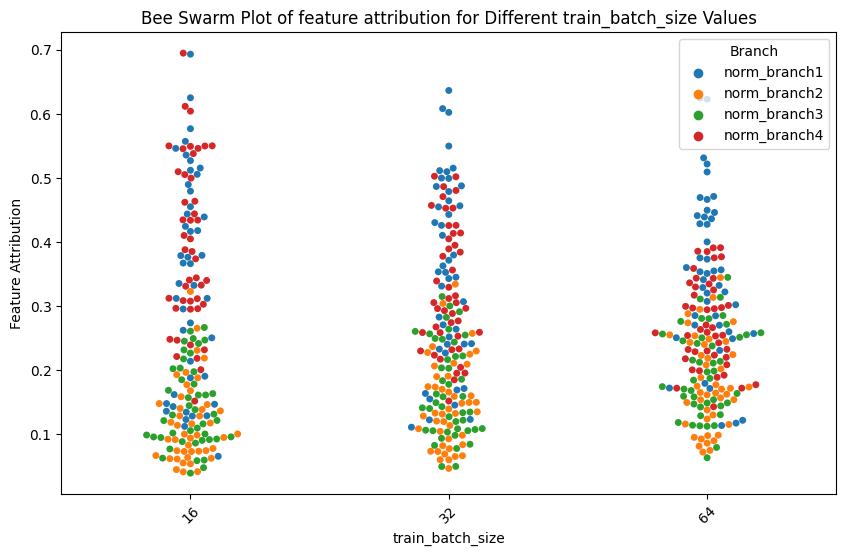

In [18]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(normalized_df_highacc, hyperparam, variables)

# Paired T test

In [19]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [20]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [21]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [22]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [23]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003], 'train_batch_size': [64, 32, 16]}

In [24]:
def get_significant_results(df, hyperparams_choice_list):
  values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [25]:
get_significant_results(FA_SD, hyperparams_choice_list)

Values to compare: std_norm_branch1 variable_pair: (32, 64) T-statistic: 18.54111998187439 One-sided P-value: 0.0014481319464383418




Values to compare: std_norm_branch3 variable_pair: (32, 64) T-statistic: 7.287029390833736 One-sided P-value: 0.009158150572885061


Values to compare: avg_std variable_pair: (32, 64) T-statistic: 9.400840784407034 One-sided P-value: 0.005563405509064472




#layer feature attribution rank frequency comparison

In [26]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [27]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']


In [28]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-28-799ba4b3762b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


4123    39
4213    34
3124    26
3214    18
2134    16
1324     8
2314     8
1234     8
4132     6
3142     3
4312     3
1423     3
1432     2
4231     2
4321     2
2431     1
1342     1
Name: rank_combination, dtype: int64